# Automation of Human Karyotype Analysis Using Image Segmentation and Classification Methods. Classification.

## Data and imports

In [ ]:
!gdown 1LtQZ_9ofcJfSwmEuzXHnAJrgGyDab_Xw

Downloading...
From (original): https://drive.google.com/uc?id=1LtQZ_9ofcJfSwmEuzXHnAJrgGyDab_Xw
From (redirected): https://drive.google.com/uc?id=1LtQZ_9ofcJfSwmEuzXHnAJrgGyDab_Xw&confirm=t&uuid=f537b129-9296-4155-9d71-bb166395595f
To: /content/Data.zip
100% 1.04G/1.04G [00:08<00:00, 121MB/s]


In [ ]:
!unzip /content/Data.zip

Streaming output truncated to the last 5000 lines.
  inflating: 24_chromosomes_object/annotations/1080893.xml  
  inflating: 24_chromosomes_object/annotations/1080894.xml  
  inflating: 24_chromosomes_object/annotations/1080902.xml  
  inflating: 24_chromosomes_object/annotations/1080903.xml  
  inflating: 24_chromosomes_object/annotations/1080904.xml  
  inflating: 24_chromosomes_object/annotations/1080911.xml  
  inflating: 24_chromosomes_object/annotations/1080914.xml  
  inflating: 24_chromosomes_object/annotations/1080921.xml  
  inflating: 24_chromosomes_object/annotations/1080922.xml  
  inflating: 24_chromosomes_object/annotations/1080923.xml  
  inflating: 24_chromosomes_object/annotations/1080924.xml  
  inflating: 24_chromosomes_object/annotations/1080931.xml  
  inflating: 24_chromosomes_object/annotations/1080933.xml  
  inflating: 24_chromosomes_object/annotations/1080934.xml  
  inflating: 24_chromosomes_object/annotations/1080941.xml  
  inflating: 24_chromosomes_object

In [ ]:
!rm -f /content/*.txt
!rm -f /content/*.csv
!rm -rf /content/weight

In [ ]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.8 MB/s eta 0:00:00


In [ ]:
import os
import glob
import random
import xml.etree.ElementTree as ET
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights, mobilenet_v2, MobileNet_V2_Weights
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from torcheval.metrics.functional import multiclass_f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Preparing for training

In [ ]:
xml_folder = '/content/24_chromosomes_object/annotations'
image_folder = '/content/24_chromosomes_object/JEPG'
output_folder = '/content/24_chromosomes_cropped'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for xml_file in os.listdir(xml_folder):
    if not xml_file.endswith('.xml'):
        continue

    if xml_file == "103064.xml" or xml_file == "1050431.xml":
        continue

    xml_path = os.path.join(xml_folder, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename = root.find('filename').text
    image_path = os.path.join(image_folder, filename)
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        continue

    img = Image.open(image_path).convert('RGB')

    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        cropped = img.crop((xmin, ymin, xmax, ymax))

        label_folder = os.path.join(output_folder, label)
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)

        base_name = os.path.splitext(filename)[0]
        cropped_filename = f"{base_name}_{xmin}_{ymin}_{xmax}_{ymax}.jpg"
        cropped.save(os.path.join(label_folder, cropped_filename))

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

dataset = ImageFolder(root=output_folder, transform=transform)

print("Number of classes:", len(dataset.classes))
print("Classes:", dataset.classes)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Number of classes: 24
Classes: ['A1', 'A2', 'A3', 'B4', 'B5', 'C10', 'C11', 'C12', 'C6', 'C7', 'C8', 'C9', 'D13', 'D14', 'D15', 'E16', 'E17', 'E18', 'F19', 'F20', 'G21', 'G22', 'X', 'Y']
Train samples: 183807, Validation samples: 45952


In [ ]:
num_classes = len(dataset.classes)
num_epochs = 5

def create_resnet18(num_classes, device, pretrained):
    """Returns ResNet-18 model"""
    if pretrained:
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
    else:
        model = resnet18(weights=None)

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model.to(device)

def create_mobilenet_v2(num_classes, device, pretrained):
    """Returns MobilentV2 model"""
    if pretrained:
        model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
    else:
        model = mobilenet_v2(weights=None)

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model.to(device)

def plot_metrics(history):
    """Plots history of training (metrics)"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(history['train_acc'], label='Train Acc')
    axes[0].plot(history['val_acc'],   label='Val Acc')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].set_title('Training vs Validation Accuracy')
    axes[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    axes[0].legend()

    axes[1].plot(history['train_f1'], label='Train F1')
    axes[1].plot(history['val_f1'],   label='Val F1')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('F1 Score (%)')
    axes[1].set_title('Training vs Validation F1 Score')
    axes[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    axes[1].legend()

    plt.tight_layout()
    plt.show()

def train_model(model, train_loader, val_loader, num_epochs, device):
    """Training function"""
    history = {'train_loss': [], 'train_acc': [], 'train_f1': [],
               'val_loss': [], 'val_acc': [], 'val_f1': []}

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

        epoch_loss = running_loss / len(train_loader.dataset)

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        epoch_acc = (all_preds == all_labels).float().mean().item() * 100
        epoch_f1 = multiclass_f1_score(all_preds, all_labels, num_classes=24, average="weighted") * 100

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['train_f1'].append(epoch_f1)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, F1: {epoch_f1:.2f}%")

        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)

                preds = torch.argmax(outputs, dim=1)
                val_preds.append(preds.cpu())
                val_labels.append(labels.cpu())

        val_loss = val_loss / len(val_loader.dataset)

        val_preds  = torch.cat(val_preds)
        val_labels = torch.cat(val_labels)

        val_acc = (val_preds == val_labels).float().mean().item() * 100
        val_f1 = multiclass_f1_score(val_preds, val_labels, num_classes=24, average="weighted") * 100

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, F1: {val_f1:.2f}%\n")
        print("--------------------------------------------")

    return history

## Resnet-18

Training ResNet-18 (pretrained):


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 70.0MB/s]


Epoch 1/5
Train Loss: 0.3862, Acc: 88.44%, F1: 88.43%
Val Loss: 0.1331, Acc: 96.08%, F1: 96.09%

--------------------------------------------
Epoch 2/5
Train Loss: 0.1274, Acc: 96.26%, F1: 96.26%
Val Loss: 0.1056, Acc: 96.95%, F1: 96.95%

--------------------------------------------
Epoch 3/5
Train Loss: 0.0857, Acc: 97.50%, F1: 97.50%
Val Loss: 0.1036, Acc: 97.07%, F1: 97.06%

--------------------------------------------
Epoch 4/5
Train Loss: 0.0624, Acc: 98.17%, F1: 98.17%
Val Loss: 0.0839, Acc: 97.73%, F1: 97.73%

--------------------------------------------
Epoch 5/5
Train Loss: 0.0471, Acc: 98.61%, F1: 98.60%
Val Loss: 0.0932, Acc: 97.60%, F1: 97.60%

--------------------------------------------


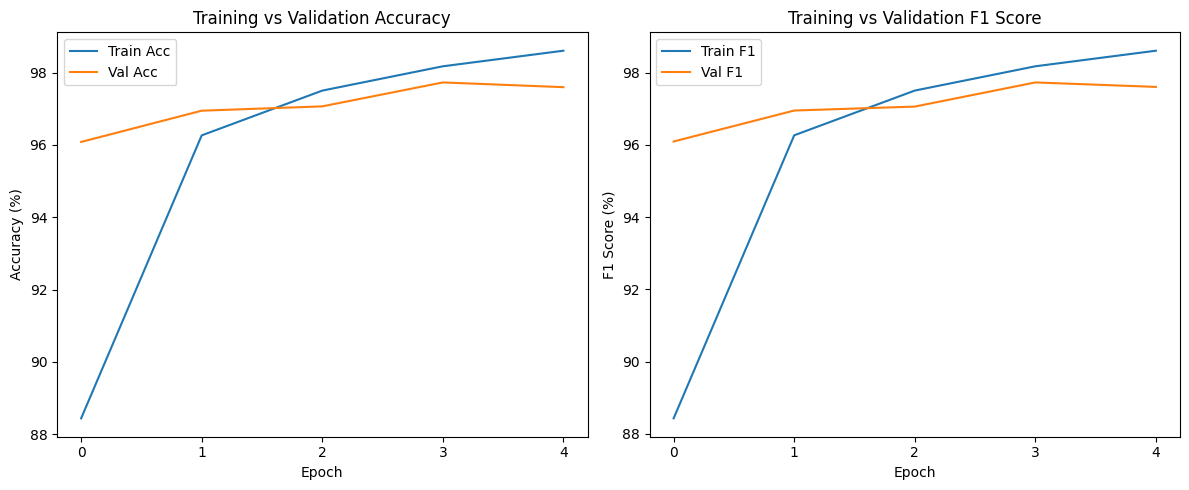

In [ ]:
print("Training ResNet-18 (pretrained):")
model_resnet_pretrained = create_resnet18(num_classes, device, True)
history = train_model(model_resnet_pretrained, train_loader, val_loader, num_epochs, device)
torch.save(model_resnet_pretrained.state_dict(), "ResNet18_pretrained.pth")

plot_metrics(history)

Training ResNet-18 (not pretrained):
Epoch 1/5
Train Loss: 0.6895, Acc: 79.01%, F1: 78.97%
Val Loss: 0.2662, Acc: 92.05%, F1: 92.10%

--------------------------------------------
Epoch 2/5
Train Loss: 0.2179, Acc: 93.49%, F1: 93.49%
Val Loss: 0.1703, Acc: 94.89%, F1: 94.92%

--------------------------------------------
Epoch 3/5
Train Loss: 0.1485, Acc: 95.60%, F1: 95.60%
Val Loss: 0.1738, Acc: 94.77%, F1: 94.79%

--------------------------------------------
Epoch 4/5
Train Loss: 0.1125, Acc: 96.66%, F1: 96.66%
Val Loss: 0.1309, Acc: 96.13%, F1: 96.13%

--------------------------------------------
Epoch 5/5
Train Loss: 0.0885, Acc: 97.36%, F1: 97.36%
Val Loss: 0.1174, Acc: 96.66%, F1: 96.66%

--------------------------------------------


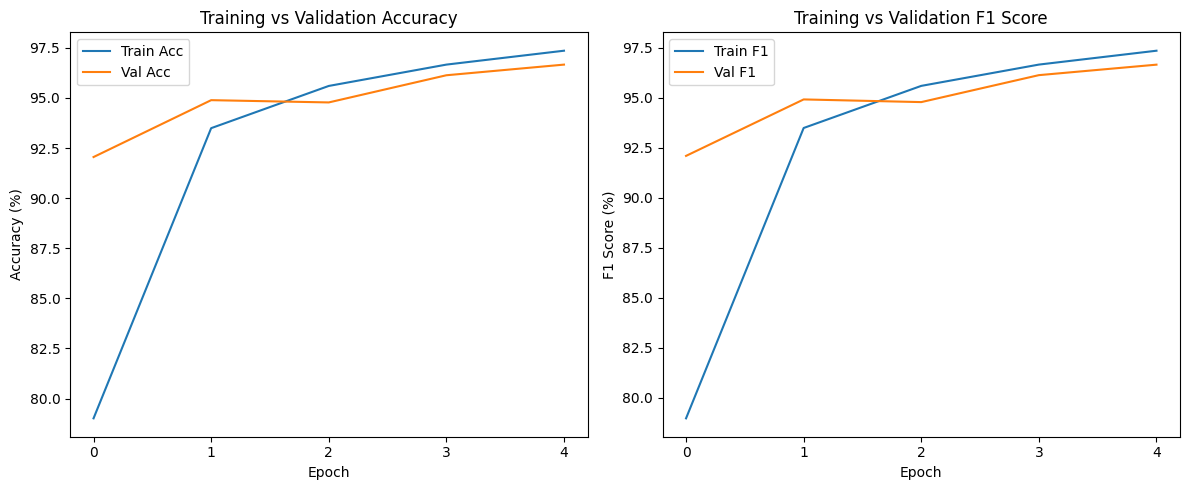

In [ ]:
print("Training ResNet-18 (not pretrained):")
model_resnet_n_pretrained = create_resnet18(num_classes, device, False)
history = train_model(model_resnet_n_pretrained, train_loader, val_loader, num_epochs, device)
torch.save(model_resnet_n_pretrained.state_dict(), "ResNet18_not_pretrained.pth")

plot_metrics(history)

## MobileNetV2

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


Training MobileNetV2 (pretrained):


100%|██████████| 13.6M/13.6M [00:00<00:00, 60.8MB/s]


Epoch 1/5
Train Loss: 0.5558, Acc: 83.04%, F1: 83.01%
Val Loss: 0.1233, Acc: 96.41%, F1: 96.41%

--------------------------------------------
Epoch 2/5
Train Loss: 0.1274, Acc: 96.27%, F1: 96.27%
Val Loss: 0.1017, Acc: 97.13%, F1: 97.13%

--------------------------------------------
Epoch 3/5
Train Loss: 0.0873, Acc: 97.51%, F1: 97.51%
Val Loss: 0.0757, Acc: 97.95%, F1: 97.96%

--------------------------------------------
Epoch 4/5
Train Loss: 0.0679, Acc: 98.06%, F1: 98.06%
Val Loss: 0.0762, Acc: 97.94%, F1: 97.94%

--------------------------------------------
Epoch 5/5
Train Loss: 0.0541, Acc: 98.40%, F1: 98.40%
Val Loss: 0.0748, Acc: 98.07%, F1: 98.08%

--------------------------------------------


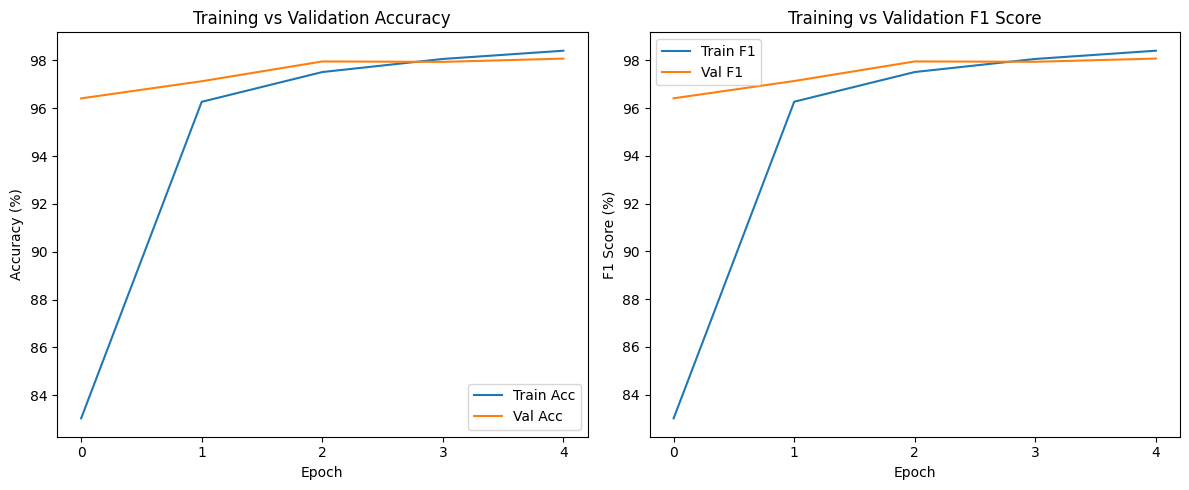

In [ ]:
print("Training MobileNetV2 (pretrained):")
model_mobilenet_pretrained = create_mobilenet_v2(num_classes, device, True)
history = train_model(model_mobilenet_pretrained, train_loader, val_loader, num_epochs, device)
torch.save(model_mobilenet_pretrained.state_dict(), "MobileNetV2_pretrained.pth")

plot_metrics(history)

Training MobileNetV2 (not pretrained):
Epoch 1/5
Train Loss: 1.4330, Acc: 53.66%, F1: 53.42%
Val Loss: 0.4501, Acc: 86.30%, F1: 86.35%

--------------------------------------------
Epoch 2/5
Train Loss: 0.3825, Acc: 88.37%, F1: 88.37%
Val Loss: 0.2196, Acc: 93.34%, F1: 93.35%

--------------------------------------------
Epoch 3/5
Train Loss: 0.2262, Acc: 93.13%, F1: 93.13%
Val Loss: 0.1662, Acc: 95.05%, F1: 95.06%

--------------------------------------------
Epoch 4/5
Train Loss: 0.1633, Acc: 95.07%, F1: 95.07%
Val Loss: 0.1302, Acc: 96.19%, F1: 96.19%

--------------------------------------------
Epoch 5/5
Train Loss: 0.1319, Acc: 96.02%, F1: 96.02%
Val Loss: 0.1207, Acc: 96.48%, F1: 96.48%

--------------------------------------------


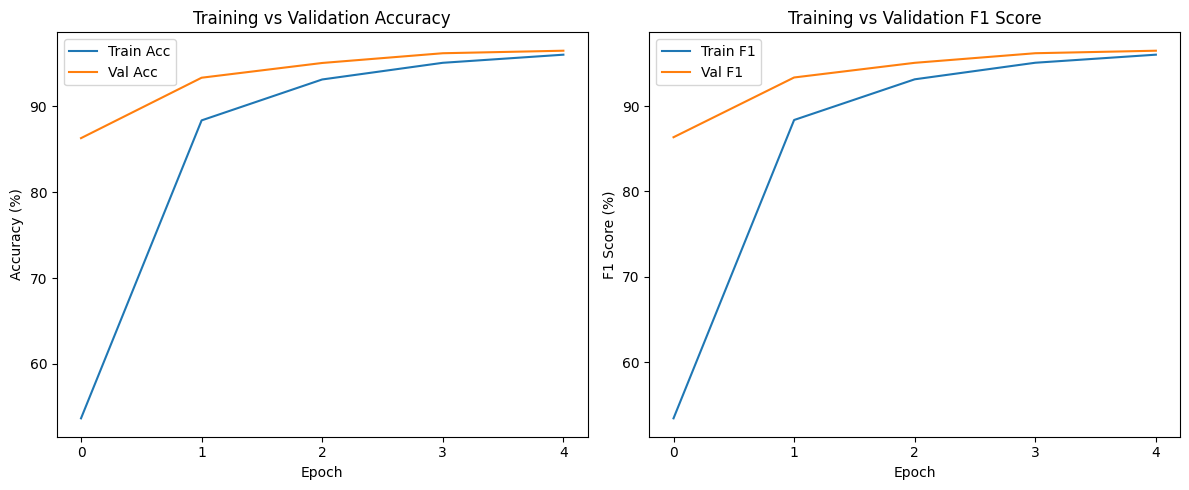

In [ ]:
print("Training MobileNetV2 (not pretrained):")
model_mobilenet_n_pretrained = create_mobilenet_v2(num_classes, device, False)
history = train_model(model_mobilenet_n_pretrained, train_loader, val_loader, num_epochs, device)
torch.save(model_mobilenet_n_pretrained.state_dict(), "MobileNetV2_not_pretrained.pth")

plot_metrics(history)

## Models' predictions

Predicted label by ResNet18 (pretrained): B4
Predicted label by ResNet18 (not pretrained): B4
Predicted label by MobileNetV2 (pretrained): B4
Predicted label by MobileNetV2 (not pretrained): B4


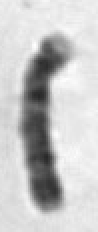

In [ ]:
def classify_chromosome(model, image_path, transform, device, class_names):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_t)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]
    return predicted_class

test_image_path = '/content/model_check.png'

predicted_label = classify_chromosome(model_resnet_pretrained, test_image_path, transform, device, dataset.classes)
print("Predicted label by ResNet18 (pretrained):", predicted_label)
predicted_label = classify_chromosome(model_resnet_n_pretrained, test_image_path, transform, device, dataset.classes)
print("Predicted label by ResNet18 (not pretrained):", predicted_label)

predicted_label = classify_chromosome(model_mobilenet_pretrained, test_image_path, transform, device, dataset.classes)
print("Predicted label by MobileNetV2 (pretrained):", predicted_label)
predicted_label = classify_chromosome(model_mobilenet_n_pretrained, test_image_path, transform, device, dataset.classes)
print("Predicted label by MobileNetV2 (not pretrained):", predicted_label)

img = Image.open("/content/model_check.png").convert('RGB')
img

Below the one see two B4 chromosomes that were taken out the dataset

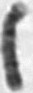

In [ ]:
img = Image.open("/content/24_chromosomes_object/JEPG/103064.jpg").convert('RGB')
cropped = img.crop((472, 208, 505, 301))
cropped

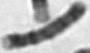

In [ ]:
img = Image.open("/content/24_chromosomes_object/JEPG/103064.jpg").convert('RGB')
cropped = img.crop((240, 116, 330, 169))
cropped